## Numerische Mathematik I: Implementation of Linear and Non-Linear Image Filters

Technische Universität Berlin, Straße des 17. Juni 135, 10623 Berlin, Deutschland

---

### Hausaufgabengruppe 20

**Franklin Liu** (Mat.-Nr: 454668) 

E-mail: franklin.f.liu@campus.tu-berlin.de

**Aleksandra Soloveva** (Mat.-Nr: 452931)

E-mail: soloveva@campus.tu-berlin.de

**Allan A. Zea** (Mat.-Nr: 412666)

E-mail: zealobo@campus.tu-berlin.de

---

In dieser Programmieraufgabe werden wir eine Reihe von linearen und nicht-linearen Filtern in Python implementieren, um das Rauschen auf den folgenden drei Bildern zu entfernen. Wir verwenden dabei außer `skimage`, `numpy` und `matplotlib` keine weiteren Pakete.

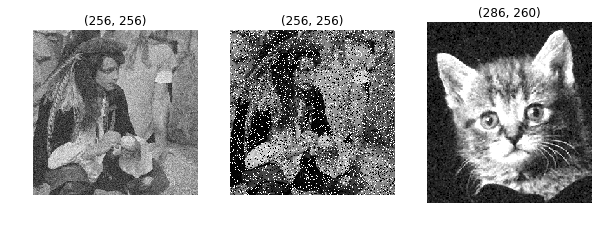

In [14]:
import skimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

B1 = mpimg.imread('B1.png')
B2 = mpimg.imread('B2.png')
C = mpimg.imread('C.png')

bilder = [B1, B2, C]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
for ax, bild in zip(axes.flat, bilder):
    ax.imshow(bild, cmap = 'gray')
    ax.set(title = bild.shape)
    ax.axis('off')

plt.show()

$~~~~~~~~$

---

$~~~~$

**Aufgabe 1.** Implementiere jeweils eine Funktion, welche den gewichteten Mittelwert und den gewichteten Median 
$$\overline{A}_W :=\sum_{k=1}^n\sum_{l=1}^m W(k,l)A(k,l)\quad\textrm{und}\quad\tilde{A}_W:=\textrm{median}_W(A)$$
für eine beliebige Matrix $A\in\mathbb{R}^{n\times m}$ und die Gewichte $W\in\mathbb{R}^{n\times m}$ mit $W(k, l)\geq 0$ und $\sum_{k=1}^n\sum_{l=1}^m W(k,l)=1$ berechnet. Für den Median darf die Funktion `sort` von NumPy verwendet werden. Um die beiden Funktionen zu testen, erzeuge 100 Zufallsmatrizen unterschiedlicher Größe und vergleiche die Ergebnisse mit den NumPyFunktionen `mean` und `median` für den gleichgewichteten Fall. Gebe hierfür die maximale absolute Abweichung aus.

---

**Lösung.**

In [2]:
def gewichteter_mittelwert(A, W):
    return np.sum(A * W)


def gewichteter_median(A, W):
    indizes = np.unravel_index(np.argsort(A, axis = None), A.shape)
    
    i = 0
    gewicht_summe = 0
    while gewicht_summe < 0.5:
        gewicht_summe += W[indizes[0][i], indizes[1][i]]
        i += 1

    if gewicht_summe == 0.5:
        return 0.5 * (A[indizes[0][i], indizes[1][i]] + A[indizes[0][i + 1], indizes[1][i + 1]])

    return A[indizes[0][i], indizes[1][i]]

In [4]:
def abweichung(lageparameter, tests):
    werte = np.zeros(tests)
    for i in range(tests):
        s = (np.random.randint(2, 50), np.random.randint(2, 50))
        A = np.random.randint(0, 255, s)
        W = np.random.randint(0, 255, s)
        W = W / np.sum(W)
        werte[i] = lageparameter(A,W)
    return np.median(np.absolute(werte - np.mean(werte)))

In [5]:
tests = 100

print("Die maximale absolute Abweichung der gewichteten Mittelwert Funktion beträgt {0:.3} mit {1} Zufallsmatrizen.".format(abweichung(gewichteter_mittelwert, tests), tests))
print("Die maximale absolute Abweichung der gewichteten Median Funktion beträgt {0:.3} mit {1} Zufallsmatrizen.".format(abweichung(gewichteter_median, tests), tests))

Die maximale absolute Abweichung der gewichteten Mittelwert Funktion beträgt 2.52 mit 100 Zufallsmatrizen.
Die maximale absolute Abweichung der gewichteten Median Funktion beträgt 5.0 mit 100 Zufallsmatrizen.


$~~~~~~~~~~$

---

$~~~~$

**Aufgabe 2.** Implementiere den gewichteten Mittelwertfilter 
$$U(k, l):=\sum_{(i,j)\in\mathcal{N}(k,l)}B(i,j)W(i-k,j-l)$$
mit $\mathcal{N}(k,l):=\left\{(i,j):|i-k|\leq s,|j-l|\leq s\right\}$ für ein Bild $B\in\mathbb{R}^{n\times m}$ und Gewichte
$W\in\mathbb{R}^{(2s+1)\times (2s+1)}$ mit $W(k,l)\geq0$ und $\sum_{k=-s}^s\sum_{l=-s}^s W(l,k)=1$. Beachte, dass die Gewichte $W$ hier nicht gespiegelt werden! Für die Pixel am Rand setze das Bild geeignet fort. Glätte alle drei Bilder, mit geeigneten rechteckigen Mittelwertfiltern und
geeigneten Gauß-Filtern und gebe die Ergebnisse auf den Bildschirm aus. Gib die Gewichte für einen Gauß-Filter ebenfalls als Bild aus.

---

**Lösung.** Zunächst implementieren wir für das Bild $B$ und die Gewichte $W$ eine diskrete Faltungsfunktion `faltung`, welche für das eigentliche Filtern von $B$ bezüglich $W$ zuständig ist. Mitilfe dieser Funktion definieren wir dann eine Funktion `filter`, die das Glätten des Eingangsbildes mit geeigneten rechteckigen Mittelwertfiltern bzw. Gauß-Filtern durchführt. Dabei ermöglichen wir, den betrachteten Lageparameter (wie z.B. den gewichteten Mittelwert bzw. Median) festzulegen, was wir uns später in Aufgabe 3 zunutze machen.

In [6]:
def faltung(B, W, lageparameter):
    # Höhe und Breite des Bildes B und der Gewichtenmatrix W
    B_h, B_b = B.shape[0], B.shape[1]
    W_h, W_b = W.shape[0], W.shape[1]
    
    # Setze die Pixel am Rand mittels Null-Fortsetzung fort 
    # https://numpy.org/doc/stable/reference/generated/numpy.pad.html
    B_pad = np.pad(B, pad_width = ((W_h // 2, W_h // 2), (W_b // 2, W_b // 2)), mode = 'constant', constant_values = 0)
    
    h, b = (W_h // 2), (W_b // 2)
    U = np.zeros(B_pad.shape)
    for k in range(h, B_pad.shape[0] - h):
        for l in range(b, B_pad.shape[1] - b):
            temp = B_pad[(k - h):(k - h + W_h), (l - b):(l - b + W_b)]
            U[k][l] = lageparameter(temp, W)

    if h == 0:
        return U
        
    return U[h:-h, b:-b]

In [7]:
def filter(B, lageparameter, s = 1, sigma = 1.3, typ = 'gauss'):
    
    def gauss_filter(B, sigma, lageparameter):
        # Wir definieren die Länge 2s+1 unseres Gauß-Filters mit 
        # s = int(3 * sigma) und eine 'leere' (2s+1)x(2s+1)-Gewichtenmatrix
        laenge = 2 * int(3 * sigma + 0.5) + 1
        W = np.zeros((laenge, laenge))

        s = laenge // 2
        for k in range(-s, s + 1):
            for l in range(-s, s + 1):
                W[k + s, l + s] = np.exp(-(k**2 + l**2) / (2 * sigma**2))

        W = W/ np.sum(W)

        B = np.asarray(B)
        ergebnis = np.zeros(B.shape)
        ergebnis = faltung(B, W, lageparameter)

        return (ergebnis, W)
    
    def rechteckiger_filter(B, s, lageparameter):
        # Wir definieren eine (2s+1)x(2s+1)-Gewichtenmatrix
        # mit gleichmäßigen Gewichten w = 1/((2s+1)^2)
        W = np.full((2*s + 1, 2*s + 1), 1/((2*s + 1)**2))
        
        B = np.asarray(B)
        ergebnis = faltung(B, W, lageparameter)
        return (ergebnis, W)
    
    if typ == 'gauss':
        return gauss_filter(B, sigma, lageparameter)
    elif typ == 'rechteckig':
        return rechteckiger_filter(B, s, lageparameter)
    else:
        raise AssertionError('Waehle einen gueltigen Filtertyp')

### Test: Gauß-Filter

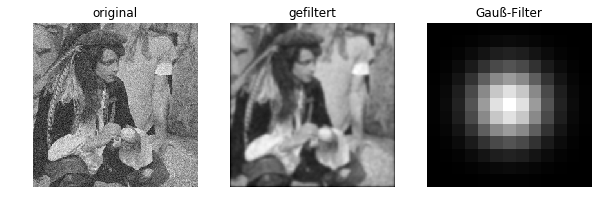

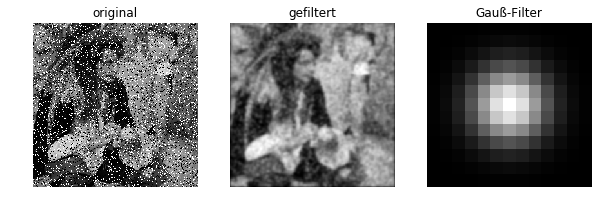

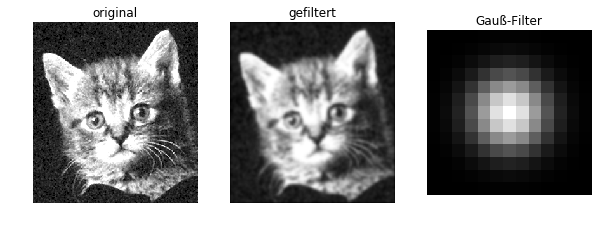

In [8]:
for bild in bilder:
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
    gefiltert  = filter(bild, gewichteter_mittelwert, sigma = 2, typ = 'gauss')
    ergebnis = [bild, gefiltert[0], gefiltert[1]]
    for ax, k in zip(axes.flat, range(3)):
        ax.imshow(ergebnis[k], cmap = 'gray')
        if k == 0: 
            ax.set(title = 'original')
        if k == 1: 
            ax.set(title = 'gefiltert')
        if k == 2: 
            ax.set(title = 'Gauß-Filter')
        ax.axis('off')
    plt.show()

### Test: Rechteckiger Mittelwertfilter

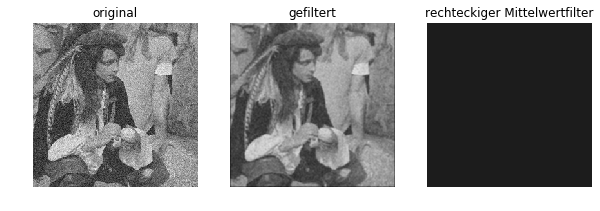

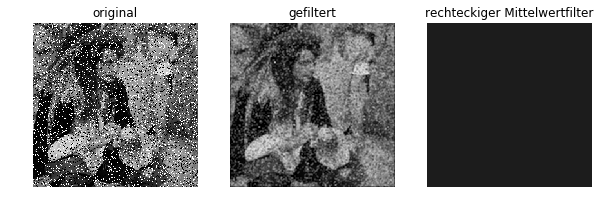

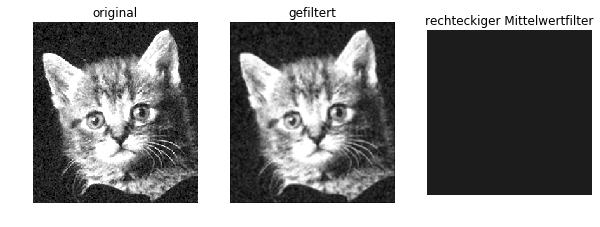

In [9]:
for bild in bilder:
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
    gefiltert  = filter(bild, gewichteter_mittelwert, s = 1, typ = 'rechteckig')
    ergebnis = [bild, gefiltert[0], gefiltert[1]]
    for ax, k in zip(axes.flat, range(3)):
        ax.imshow(ergebnis[k], cmap = 'gray', vmin = 0, vmax = 1)
        if k == 0: 
            ax.set(title = 'original')
        if k == 1: 
            ax.set(title = 'gefiltert')
        if k == 2: 
            ax.set(title = 'rechteckiger Mittelwertfilter')
        
        ax.axis('off')
    plt.show()

$~~~~~~~~$

---

$~~~~$

**Aufgabe 3.** Implementiere den gewichteten Medianfilter
$$U(k,l):=\textrm{median}_W(B(i,j))_{(i,j)\in\mathcal{N}(k,l)}$$ 
mit $\mathcal{N}(k,l):=\left\{(i,j):|i-k|\leq s, |j-l|\leq s\right\}$ für ein Bild $B\in\mathbb{R}^{n\times m}$ und Gewichte $W\in\mathbb{R}^{(2s+1)\times(2s+1)}$ mit $W(k,l)\geq0$ und $\sum_{k=-s}^s\sum_{l=-s}^s W(l,k)=1$. Für die Pixel am Rand setze das Bild geeignet fort. Glätte alle drei Bilder, mit (ungewichteten) Median-Filtern geeigneter Größe und gewichteten Median-Filtern mit Gauß-Gewichten geeigneter Varianz und gebe die Ergebnisse auf den Bildschirm aus.

---

**Lösung.** Nun sind wir in der Lage, den gewichteten Medianfilter zu testen, indem wir die in Aufgabe 2 definierte `filter`-Funktion aufrufen und dabei den Median (d.h. die dafür bestimmte Funktion `gewichteter_median` aus Aufgabe 1) als Lageparameter festlegen.

### Test: Ungewichteter Median-Filter

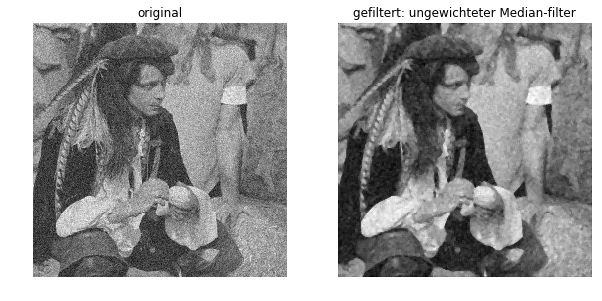

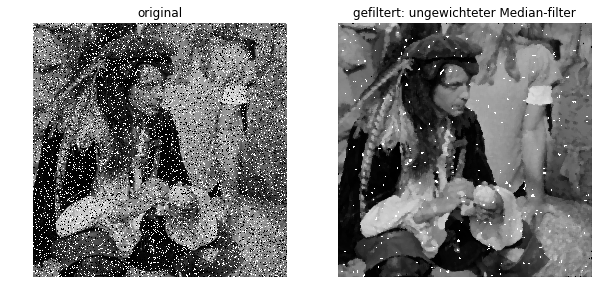

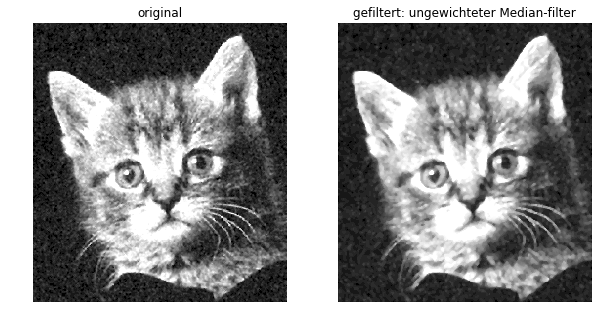

In [10]:
for bild in bilder:
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10))
    gefiltert  = filter(bild, gewichteter_median, s = 1, typ = 'rechteckig')
    ergebnis = [bild, gefiltert[0], gefiltert[1]]
    for ax, k in zip(axes.flat, range(3)):
        ax.imshow(ergebnis[k], cmap = 'gray')
        if k == 0: 
            ax.set(title = 'original')
        if k == 1: 
            ax.set(title = 'gefiltert: ungewichteter Median-filter')
        ax.axis('off')
    plt.show()

### Test: Median-Filter mit Gauß-Gewichten

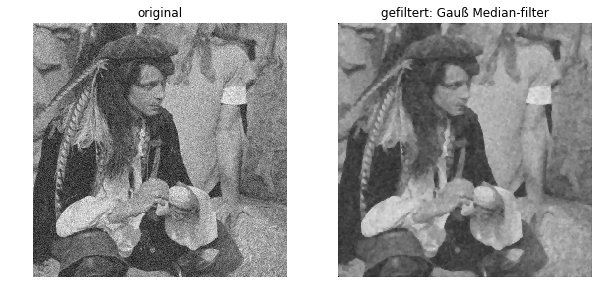

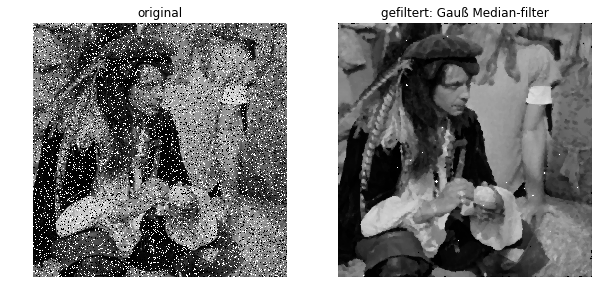

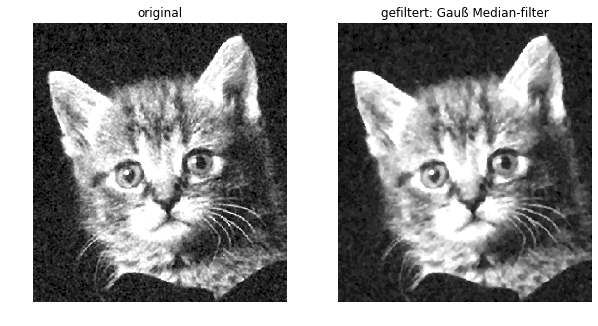

In [11]:
for bild in bilder:
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10))
    gefiltert  = filter(bild, gewichteter_median, sigma = 1, typ = 'gauss')
    ergebnis = [bild, gefiltert[0]]
    for ax, k in zip(axes.flat, range(3)):
        ax.imshow(ergebnis[k], cmap = 'gray', vmin = 0, vmax = 1)
        if k == 0: 
            ax.set(title = 'original')
        if k == 1: 
            ax.set(title = 'gefiltert: Gauß Median-filter')
        ax.axis('off')
    plt.show()

$~~~~~~~~$

---

$~~~~$

**Aufgabe 4.** Implementiere den bilateralen Filter für Gauß-Gewichte. Für die Pixel am Rand setze
das Bild geeignet fort. Glätte alle drei Bilder mit passenden Parametern und gebe die
Ergebnisse auf den Bildschirm aus.

---

**Lösung.** In dieser Aufgabe erstellen wir eine Gewichtenmatrix mithilfe der Gleichungen auf Folie 31 des aufgezeichneten Materials auf der Numerik-I-ISIS-Seite und führen eine Faltung durch, wie wir es bisher gemacht haben.

In [12]:
def bilateraler_filter(B, s = 1, sigma1 = 0.3, sigma2 = 0.75):
    
    def w_s(x, y, sigma1):
        return np.exp(-(x**2 + y**2) / (2 * sigma1**2))
    
    def w_r(x, sigma2):
        return np.exp(-(x**2) / (2 * sigma2**2))

    laenge = 2 * s + 1
    quotienten = np.zeros((laenge, laenge))
    for k in range(-s, s + 1):
        for l in range(-s, s + 1):  
            totaler_gewicht = 0
            for u in range(k - s, k + s + 1):
                for v in range(l - s, l + s + 1):
                    totaler_gewicht += w_s(k + s - u, l + s - v, sigma1) * w_r(B[k + s, l + s] - B[u, v], sigma2)
            quotienten[k + s, l + s] = totaler_gewicht

    W = np.zeros((laenge, laenge))
    for k in range(-s, s + 1):
        for l in range(-s, s + 1): 
            for i in range(k - s, k + s + 1):
                for j in range(l - s, l + s + 1):
                    W[k + s, l + s] = (w_s(k + s - i, l + s - j, sigma1) * w_r(B[k + s, l + s] - B[i, j], sigma2)) / quotienten[k + s, l + s]                  
            
    B = np.asarray(B)
    ergebnis = np.zeros(B.shape)
    ergebnis = faltung(B, W, gewichteter_mittelwert)

    return (ergebnis.astype(np.uint8), W)

### Test: Bilateraler Filter

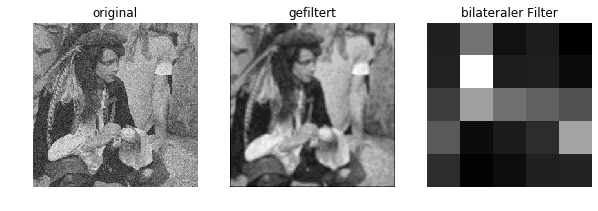

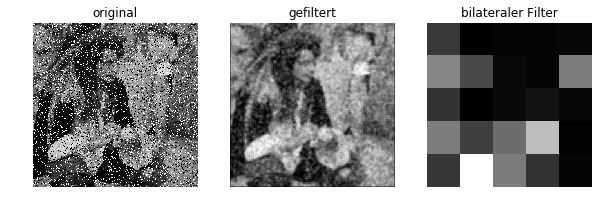

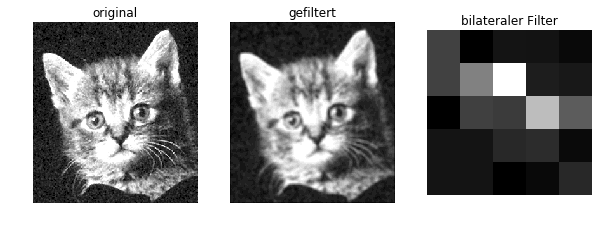

In [13]:
for bild in bilder:
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
    gefiltert  = bilateraler_filter(bild, s = 2, sigma1 = 0.3, sigma2 = 0.75)
    ergebnis = [bild, gefiltert[0], gefiltert[1]]
    for ax, k in zip(axes.flat, range(3)):
        ax.imshow(ergebnis[k], cmap = 'gray')
        if k == 0: 
            ax.set(title = 'original')
        if k == 1: 
            ax.set(title = 'gefiltert')
        if k == 2: 
            ax.set(title = 'bilateraler Filter')
        ax.axis('off')
    plt.show()